In [1]:
import collections
import json
import os

from absl import app
from absl import flags

import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm

2024-08-16 10:40:50.640044: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 10:40:51.339549: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
input_path = "/mnt/d/JRDB/train_dataset_with_activity/train_dataset_with_activity"
scene = "memorial-court-2019-03-16_0"

In [3]:
# from human scene transformer, data subfolder
def get_file_handle(path, mode='rt'):
  file_handle = open(path, mode)
  return file_handle
scene_data_file = get_file_handle(
      os.path.join(input_path, 'labels', 'labels_3d', scene + '.json')
  )

# get agents_dict_from_detections
scene_data = json.load(scene_data_file)
agents = collections.defaultdict(list)
for frame in scene_data['labels']:
    ts = int(frame.split('.')[0])
    for det in scene_data['labels'][frame]:
      agents[det['label_id']].append((ts, det))
agents_dict = agents

In [4]:
# get_agents_features_with_box
max_distance_to_robot = 10
agents_pos_dict = collections.defaultdict(dict)
for agent_id, agent_data in agents_dict.items():
    for (ts, agent_instance) in agent_data:
        if agent_instance['attributes']['distance'] <= max_distance_to_robot:
            agents_pos_dict[(ts, agent_id)] = {
                'timestamp:': ts,
                'agent_id': agent_id,
                'p': np.array([agent_instance['box']['cx'],
                                agent_instance['box']['cy'],
                                agent_instance['box']['cz']]),
                # rotation angle is relative to negatiev x axis of robot
                'yaw': np.pi - agent_instance['box']['rot_z'],
                'l': agent_instance['box']['l'],
                'w': agent_instance['box']['w'],
                'h': agent_instance['box']['h']
            }
agents_features = agents_pos_dict

In [5]:
agents_df = pd.DataFrame.from_dict(
        agents_features, orient='index'
    ).rename_axis(['timestep', 'id']) 

In [43]:
agents_df

,,timestamp:,agent_id,p,yaw,l,w,h
timestep,id,,,,,,,
929,pedestrian:50,929,pedestrian:50,"[8.0775, 5.92577, -0.1398]",7.388463,0.95,0.60,1.73934
930,pedestrian:50,930,pedestrian:50,"[7.98614, 5.9973, -0.14079]",7.397673,0.95,0.60,1.73934
931,pedestrian:50,931,pedestrian:50,"[7.89479, 6.06883, -0.14179]",7.406883,0.95,0.60,1.73934
932,pedestrian:50,932,pedestrian:50,"[7.79872, 6.15206, -0.14278]",7.417543,0.95,0.60,1.73934
933,pedestrian:50,933,pedestrian:50,"[7.70265, 6.23528, -0.14376]",7.428203,0.95,0.60,1.73934
...,...,...,...,...,...,...,...,...
1077,pedestrian:3,1077,pedestrian:3,"[-9.11771, 1.46731, -0.00774]",3.252423,0.98,0.63,1.96452
1078,pedestrian:3,1078,pedestrian:3,"[-9.27479, 1.37772, -0.00774]",3.246293,0.98,0.63,1.96452
1079,pedestrian:3,1079,pedestrian:3,"[-9.4474, 1.35886, -0.00774]",3.245083,0.98,0.63,1.96452


In [6]:
# get agents keypoints
keypoint_path = os.path.join(input_path, 'labels', 'labels_2d_pose_coco')
scene_data_file = get_file_handle(os.path.join(keypoint_path, scene + '_image0.json'))
scene_data = json.load(scene_data_file)

agents_keypoints = collections.defaultdict(dict)
image_keypoints = collections.defaultdict(dict)

for frame in scene_data['annotations']:
    agents_keypoints[frame['id']] = {
        'keypoints': np.array(frame['keypoints']).reshape(17, 3),
        'track_id': frame['track_id'],
        'timestep': frame['image_id']}
for frame in scene_data['images']:
    image_keypoints[frame['id']] = {
        'timestep': frame['id'],
        'file_name': frame['file_name']
    }

In [7]:
keypoints_df = pd.DataFrame.from_dict(
        agents_keypoints, orient='index'
    )
keypoints_df

,keypoints,track_id,timestep
4425,"[[352.1, 188.25, 2.0], [354.35, 193.64, 1.0], ...",2,2
4426,"[[280.22, 192.62, 2.0], [282.04, 196.38, 1.0],...",32,2
4427,"[[363.9, 188.15, 2.0], [366.05, 193.4, 1.0], [...",2,4
4428,"[[291.79, 193.56, 2.0], [293.8, 197.2, 1.0], [...",32,4
4429,"[[375.7, 188.18, 2.0], [377.74, 193.28, 1.0], ...",2,6
...,...,...,...
4398,"[[76.1, 140.4, 2.0], [74.4, 153.2, 2.0], [80.1...",3,999
4404,"[[60.96, 135.51, 2.0], [57.2, 146.4, 2.0], [63...",3,1001
4410,"[[40.8, 126.1, 2.0], [37.5, 138.6, 2.0], [42.6...",3,1003
4416,"[[18.5, 120.8, 2.0], [13.7, 135.7, 2.0], [20.0...",3,1005


In [8]:
# get robot odometry
def get_robot(input_path, scene):
  """Returns robot features from raw data."""
  odom_data_file = get_file_handle(
      os.path.join(input_path, scene + '.json'))
  odom_data = json.load(odom_data_file)

  robot = collections.defaultdict(list)

  for pc_ts, pose in odom_data['odometry'].items():
    ts = int(pc_ts.split('.')[0])
    robot[ts] = {
        'p': np.array([pose['position']['x'],
                       pose['position']['y'],
                       pose['position']['z']]),
        'q': np.array([pose['orientation']['x'],
                       pose['orientation']['y'],
                       pose['orientation']['z'],
                       pose['orientation']['w']]),
    }

  return robot
odom_data_file = os.path.join(input_path, 'odometry', 'train')
odom_dict = get_robot(odom_data_file, scene)

In [10]:
robot_df = pd.DataFrame.from_dict(odom_dict, orient='index').rename_axis(  
        ['timestep']
    )
# Remove extra data odometry datapoints
robot_df = robot_df.iloc[agents_df.index.levels[0]]
robot_df

,p,q
timestep,,
0,"[113.95150756835938, -127.28856658935547, 0.0]","[0.0, -0.0, -0.01763809449020721, -0.999844436..."
1,"[114.01473236083984, -127.28593444824219, 0.0]","[0.0, -0.0, -0.02320662210456262, -0.999730690..."
2,"[114.0782699584961, -127.28254699707031, 0.0]","[0.0, -0.0, -0.02945077493236543, -0.999566231..."
3,"[114.13249969482422, -127.27896881103516, 0.0]","[0.0, -0.0, -0.03556058731885938, -0.999367522..."
4,"[114.19660186767578, -127.27384185791016, 0.0]","[0.0, -0.0, -0.043115208721512865, -0.99907010..."
...,...,...
1084,"[167.41485595703125, -95.12646484375, 0.0]","[0.0, -0.0, -0.49852770561116355, -0.866873766..."
1085,"[167.43753051757812, -95.08740234375, 0.0]","[0.0, -0.0, -0.4992420248503784, -0.8664625788..."
1086,"[167.46017456054688, -95.04823303222656, 0.0]","[0.0, -0.0, -0.5003094614979587, -0.8658466623..."


In [23]:
robot_df['pq'] = robot_df['p'].apply(list) + robot_df['q'].apply(list)
robot_df

,p,q,pq
timestep,,,
0,"[113.95150756835938, -127.28856658935547, 0.0]","[0.0, -0.0, -0.01763809449020721, -0.999844436...","[113.95150756835938, -127.28856658935547, 0.0,..."
1,"[114.01473236083984, -127.28593444824219, 0.0]","[0.0, -0.0, -0.02320662210456262, -0.999730690...","[114.01473236083984, -127.28593444824219, 0.0,..."
2,"[114.0782699584961, -127.28254699707031, 0.0]","[0.0, -0.0, -0.02945077493236543, -0.999566231...","[114.0782699584961, -127.28254699707031, 0.0, ..."
3,"[114.13249969482422, -127.27896881103516, 0.0]","[0.0, -0.0, -0.03556058731885938, -0.999367522...","[114.13249969482422, -127.27896881103516, 0.0,..."
4,"[114.19660186767578, -127.27384185791016, 0.0]","[0.0, -0.0, -0.043115208721512865, -0.99907010...","[114.19660186767578, -127.27384185791016, 0.0,..."
...,...,...,...
1084,"[167.41485595703125, -95.12646484375, 0.0]","[0.0, -0.0, -0.49852770561116355, -0.866873766...","[167.41485595703125, -95.12646484375, 0.0, 0.0..."
1085,"[167.43753051757812, -95.08740234375, 0.0]","[0.0, -0.0, -0.4992420248503784, -0.8664625788...","[167.43753051757812, -95.08740234375, 0.0, 0.0..."
1086,"[167.46017456054688, -95.04823303222656, 0.0]","[0.0, -0.0, -0.5003094614979587, -0.8658466623...","[167.46017456054688, -95.04823303222656, 0.0, ..."


In [24]:
image_df = pd.DataFrame.from_dict(
        image_keypoints, orient='index'
    )
image_df

,timestep,file_name
1,1,image_0/memorial-court-2019-03-16_0/000000.jpg
2,2,image_0/memorial-court-2019-03-16_0/000001.jpg
3,3,image_0/memorial-court-2019-03-16_0/000002.jpg
4,4,image_0/memorial-court-2019-03-16_0/000003.jpg
5,5,image_0/memorial-court-2019-03-16_0/000004.jpg
...,...,...
1085,1085,image_0/memorial-court-2019-03-16_0/001084.jpg
1086,1086,image_0/memorial-court-2019-03-16_0/001085.jpg
1087,1087,image_0/memorial-court-2019-03-16_0/001086.jpg
1088,1088,image_0/memorial-court-2019-03-16_0/001087.jpg


In [25]:
result = pd.merge(keypoints_df, image_df, on="timestep")
result = pd.merge(result, robot_df, on="timestep")
result

,keypoints,track_id,timestep,file_name,p,q,pq
0,"[[352.1, 188.25, 2.0], [354.35, 193.64, 1.0], ...",2,2,image_0/memorial-court-2019-03-16_0/000001.jpg,"[114.0782699584961, -127.28254699707031, 0.0]","[0.0, -0.0, -0.02945077493236543, -0.999566231...","[114.0782699584961, -127.28254699707031, 0.0, ..."
1,"[[280.22, 192.62, 2.0], [282.04, 196.38, 1.0],...",32,2,image_0/memorial-court-2019-03-16_0/000001.jpg,"[114.0782699584961, -127.28254699707031, 0.0]","[0.0, -0.0, -0.02945077493236543, -0.999566231...","[114.0782699584961, -127.28254699707031, 0.0, ..."
2,"[[363.9, 188.15, 2.0], [366.05, 193.4, 1.0], [...",2,4,image_0/memorial-court-2019-03-16_0/000003.jpg,"[114.19660186767578, -127.27384185791016, 0.0]","[0.0, -0.0, -0.043115208721512865, -0.99907010...","[114.19660186767578, -127.27384185791016, 0.0,..."
3,"[[291.79, 193.56, 2.0], [293.8, 197.2, 1.0], [...",32,4,image_0/memorial-court-2019-03-16_0/000003.jpg,"[114.19660186767578, -127.27384185791016, 0.0]","[0.0, -0.0, -0.043115208721512865, -0.99907010...","[114.19660186767578, -127.27384185791016, 0.0,..."
4,"[[375.7, 188.18, 2.0], [377.74, 193.28, 1.0], ...",2,6,image_0/memorial-court-2019-03-16_0/000005.jpg,"[114.32426452636719, -127.26101684570312, 0.0]","[0.0, -0.0, -0.055211913798632335, -0.99847465...","[114.32426452636719, -127.26101684570312, 0.0,..."
...,...,...,...,...,...,...,...
1248,"[[76.1, 140.4, 2.0], [74.4, 153.2, 2.0], [80.1...",3,999,image_0/memorial-court-2019-03-16_0/000998.jpg,"[164.84239196777344, -99.77397155761719, 0.0]","[0.0, -0.0, -0.5151583411023113, -0.8570950259...","[164.84239196777344, -99.77397155761719, 0.0, ..."
1249,"[[60.96, 135.51, 2.0], [57.2, 146.4, 2.0], [63...",3,1001,image_0/memorial-court-2019-03-16_0/001000.jpg,"[164.8853759765625, -99.693115234375, 0.0]","[0.0, -0.0, -0.5150351143098019, -0.8571690796...","[164.8853759765625, -99.693115234375, 0.0, 0.0..."
1250,"[[40.8, 126.1, 2.0], [37.5, 138.6, 2.0], [42.6...",3,1003,image_0/memorial-court-2019-03-16_0/001002.jpg,"[164.950439453125, -99.57124328613281, 0.0]","[0.0, -0.0, -0.5138621906865165, -0.8578727463...","[164.950439453125, -99.57124328613281, 0.0, 0...."
1251,"[[18.5, 120.8, 2.0], [13.7, 135.7, 2.0], [20.0...",3,1005,image_0/memorial-court-2019-03-16_0/001004.jpg,"[165.0071563720703, -99.46582794189453, 0.0]","[0.0, -0.0, -0.5121774880388216, -0.8588796311...","[165.0071563720703, -99.46582794189453, 0.0, 0..."


In [26]:
grouped_df1 = result.groupby(result['track_id'], as_index=False)['timestep'].apply(list)
grouped_df2 = result.groupby(result['track_id'], as_index=False)['file_name'].apply(list)
grouped_df3 = result.groupby(result['track_id'], as_index=False)['keypoints'].apply(list)
grouped_df4 = result.groupby(result['track_id'], as_index=False)['pq'].apply(list)
result12 = pd.merge(grouped_df1, grouped_df2, on="track_id")
grouped_result = pd.merge(result12, grouped_df3, on="track_id")
grouped_result = pd.merge(grouped_result, grouped_df4, on="track_id")
print(grouped_result)

    track_id                                           timestep  \
0          2  [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 2...   
1          3  [970, 972, 974, 976, 978, 980, 982, 984, 986, ...   
2          4  [676, 678, 680, 682, 684, 686, 688, 690, 692, ...   
3          7  [636, 638, 640, 642, 644, 646, 648, 650, 652, ...   
4         12  [640, 642, 644, 646, 648, 650, 652, 654, 656, ...   
5         17  [610, 612, 614, 616, 618, 620, 622, 624, 626, ...   
6         22  [810, 812, 814, 816, 818, 820, 822, 824, 826, ...   
7         24  [870, 872, 874, 876, 878, 880, 882, 884, 886, ...   
8         25  [540, 542, 544, 546, 548, 550, 552, 554, 556, ...   
9         26  [830, 832, 834, 836, 838, 840, 842, 844, 829, ...   
10        27  [810, 812, 814, 816, 818, 820, 822, 824, 826, ...   
11        31  [410, 412, 414, 416, 418, 420, 422, 424, 426, ...   
12        32  [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 2...   
13        47  [540, 542, 544, 546, 548, 550, 552, 554, 556, ..

In [44]:
grouped_df2_1 = agents_df.groupby(agents_df['agent_id'], as_index=False)['timestamp:'].apply(list)
grouped_df2_1 = grouped_df2_1.rename(columns={'agent_id': 'agent_id', 'timestamp:': 'timestep'})
grouped_df2_2 = agents_df.groupby(agents_df['agent_id'], as_index=False)['p'].apply(list)
grouped_df2_3 = agents_df.groupby(agents_df['agent_id'], as_index=False)['yaw'].apply(list)
grouped_result2 = pd.merge(grouped_df2_1, grouped_df2_2, on="agent_id")
grouped_result2 = pd.merge(grouped_result2, grouped_df2_3, on="agent_id")
print(grouped_result2)

         agent_id                                           timestep  \
0    pedestrian:0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
1    pedestrian:1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
2   pedestrian:12  [611, 612, 613, 614, 615, 616, 617, 618, 619, ...   
3   pedestrian:17  [584, 585, 586, 587, 588, 589, 590, 591, 592, ...   
4    pedestrian:2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
5   pedestrian:22  [802, 803, 804, 805, 806, 807, 808, 809, 810, ...   
6   pedestrian:23  [892, 893, 894, 895, 896, 897, 898, 899, 900, ...   
7   pedestrian:24  [864, 865, 866, 867, 868, 869, 870, 871, 872, ...   
8   pedestrian:25  [508, 509, 510, 511, 512, 513, 514, 515, 516, ...   
9   pedestrian:26  [790, 791, 792, 793, 794, 795, 796, 797, 798, ...   
10  pedestrian:27  [798, 799, 800, 801, 802, 803, 804, 805, 806, ...   
11  pedestrian:28  [884, 885, 886, 887, 888, 889, 890, 891, 892, ...   
12   pedestrian:3  [967, 968, 969, 970, 971, 972, 973, 974, 975,

In [45]:
# merge 2d and 3d information together by tracks of timestamps
track_dict = {}
for idx in range(grouped_result.shape[0]):
    tmp = grouped_result.iloc[idx]['timestep']
    tmp_id = grouped_result.iloc[idx]['track_id']
    print(tmp_id)
    tmp.sort()
    for index, row in grouped_result2.iterrows():
        if int(row['agent_id'][11:]) == int(tmp_id):
            #print(row['timestep'])
            # for the same track get the corresponding indices where the persons are detected at the same time
            indices1 = np.argwhere(np.isin(np.asarray(row['timestep']),np.asarray(tmp)))
            indices2 = np.argwhere(np.isin(np.asarray(tmp), np.asarray(row['timestep'])))
            # filter all relevant features by the indices
            if len(indices1) >= 15:
                positions = np.asarray(row['p'])[indices1.squeeze()]
                yaw = np.asarray(row['yaw'])[indices1.squeeze()]
                keypoints = np.asarray(grouped_result.iloc[idx]['keypoints'])[indices2.squeeze()]
                odom = np.asarray(grouped_result.iloc[idx]['pq'])[indices2.squeeze()]
                track_dict[idx] = {
                    'positions': positions,
                    'yaw': yaw,
                    'poses': keypoints,
                    'odom': odom
                }
            break


2
3
4
7
12
17
22
24
25
26
27
31
32
47
48
52


In [46]:
track_df = pd.DataFrame.from_dict(
        track_dict, orient='index'
    )
track_df

,positions,yaw,poses,odom
0,"[[9.91793, -0.05357, -0.14918], [9.91586, -0.1...","[6.404052653589793, 6.383562653589793, 6.35318...","[[[352.1, 188.25, 2.0], [354.35, 193.64, 1.0],...","[[114.0782699584961, -127.28254699707031, 0.0,..."
1,"[[8.18054, 5.27535, 0.05226], [8.02168, 5.2786...","[3.992832653589793, 3.9664526535897933, 3.9400...","[[[81.32, 167.6, 2.0], [77.98, 174.16, 2.0], [...","[[163.8523712158203, -101.21981811523438, 0.0,..."
2,"[[6.35022, 1.70409, -0.07329], [6.15, 1.67, -0...","[3.216232653589793, 3.2136726535897933, 3.2039...","[[[222.6, 169.45, 2.0], [218.73, 178.11, 2.0],...","[[151.00222778320312, -114.29327392578125, 0.0..."
3,"[[7.68768, 1.09986, 0.06993], [7.50161, 1.0661...","[3.082272653589793, 3.0890226535897933, 3.0957...","[[[277.26, 154.89, 2.0], [275.15, 165.7, 2.0],...","[[148.9622039794922, -115.7844009399414, 0.0, ..."
4,"[[4.61, 1.51, -0.22603], [4.44388, 1.52397, -0...","[3.201112653589793, 3.165292653589793, 3.12947...","[[[196.1, 188.82, 2.0], [193.05, 202.98, 2.0],...","[[149.174560546875, -115.64134979248047, 0.0, ..."
5,"[[5.67, 1.18, -0.08708], [5.4941, 1.1672, -0.0...","[3.1492726535897932, 3.157102653589793, 3.1649...","[[[250.83, 165.08, 2.0], [248.33, 176.46, 2.0]...","[[147.59747314453125, -116.65640258789062, 0.0..."
6,"[[8.62346, 2.07799, 0.00825], [8.48, 2.02, 0.0...","[3.140522653589793, 3.1450826535897933, 3.1499...","[[[237.12, 168.72, 2.0], [236.27, 175.42, 2.0]...","[[157.3794403076172, -108.83236694335938, 0.0,..."
7,"[[8.09537, 5.5012, -0.01481], [8.04764, 5.4797...","[1.885612653589793, 1.9467426535897931, 2.0193...","[[[54.26, 179.93, 2.0], [51.63, 185.68, 1.0], ...","[[159.86135864257812, -106.0570068359375, 0.0,..."
8,"[[7.71745, 2.10502, 0.04259], [7.62084, 2.0632...","[1.886972653589793, 1.857322653589793, 1.84652...","[[[212.1, 164.27, 2.0], [212.6, 171.24, 1.0], ...","[[143.8424835205078, -118.9430160522461, 0.0, ..."
9,"[[3.74758, 2.14957, -0.22246], [3.63, 2.1, -0....","[3.358762653589793, 3.4089726535897933, 3.4267...","[[[102.66, 197.43, 2.0], [98.56, 210.98, 2.0],...","[[158.2423553466797, -107.94343566894531, 0.0,..."


In [34]:
from data_math import pose3, rotation3, quaternion

In [35]:
world_pose_odometry = pose3.Pose3(
    rotation3.Rotation3(
        quaternion.Quaternion(robot_df.loc[0]['q'])), robot_df.loc[0]['p'])
odometry_pose_world = world_pose_odometry.inverse()

In [37]:
odometry_pose_world

Pose3(Rotation3(Quaternion([-0.0, 0.0, 0.01763809449020721, -0.9998444367114089])),array([-109.39104939,  131.22851662,   -0.        ]))

In [61]:
agents_dict = {}
for index, row in track_df.iterrows():
    pos = []
    pose = []
    for i in range(len(row["positions"])):
        robot_odometry_dp = {
                    'p': row["odom"][i,:3],
                    'q': row["odom"][i,3:]
                }
        world_pose_robot = pose3.Pose3(
            rotation3.Rotation3(
                quaternion.Quaternion(robot_odometry_dp['q'])),
            robot_odometry_dp['p'])
        robot_pose_agent = pose3.Pose3(
            rotation3.Rotation3.from_euler_angles(
                rpy_radians=[0., 0., row['yaw'][i]]), row['positions'][i])
        odometry_pose_agent = (odometry_pose_world * world_pose_robot
                           * robot_pose_agent)
        pos.append(odometry_pose_agent.translation)

        world_rot_robot = rotation3.Rotation3(
          quaternion.Quaternion(robot_odometry_dp['q']))
        odometry_rot_robot = odometry_pose_world.rotation * world_rot_robot
        rot_keypoints = []
        for keypoint in row['poses'][i]:
            if np.isnan(keypoint).any():
                rot_keypoints.append(keypoint)
            else:
                rot_keypoints.append(odometry_rot_robot.rotate_point(keypoint))
        rot_keypoints = np.array(rot_keypoints)
        pose.append(rot_keypoints)
    if index not in agents_dict:
        agents_dict[index] = {}
    agents_dict[index]['positions'] = np.asarray(pos)
    agents_dict[index]['poses'] = np.asarray(pose)



In [62]:
odom_track_df = pd.DataFrame.from_dict(
        agents_dict, orient='index'
    )
odom_track_df

,positions,poses
0,"[[10.043322361304789, 0.18234900445721713, -0....","[[[347.5533660112049, 196.51750627941914, 2.00..."
1,"[[52.01287322846935, 33.949268230050556, 0.052...","[[[-76.00490116151667, 170.07632815717795, 2.0..."
2,"[[41.894596178054584, 16.55827805064007, -0.07...","[[[94.98917883671442, 263.1370715120291, 2.000..."
3,"[[41.35433422795526, 15.241367555970925, 0.069...","[[[154.3295769423678, 277.57233540248524, 2.0]..."
4,"[[38.72693815615101, 14.11636471138726, -0.226...","[[[66.64527690568215, 263.94433024061146, 2.0]..."
5,"[[38.31968004999723, 13.296546777146816, -0.08...","[[[134.63514040005023, 268.403566052053, 2.0],..."
6,"[[49.17884016748558, 24.15151344412221, 0.0082...","[[[67.56377089655014, 283.0679594412595, 2.000..."
7,"[[48.30741053674434, 29.241948341219377, -0.01...","[[[-91.55169851652298, 164.12568049741543, 2.0..."
8,"[[36.06378118369862, 12.691167187721437, 0.042...","[[[113.34282230373489, 243.1551922789723, 2.0]..."
9,"[[45.925065806974395, 21.978735120613464, -0.2...","[[[-74.59090937205663, 209.65179879755303, 2.0..."


# absolute positions to relative distances

In [1]:
import pandas as pd
import numpy as np
import sklearn

In [2]:
df = pd.read_pickle("df_jrdb_augmented.pkl") 
df

,positions,poses
0,"[[1.6433, 1.31074, 0.05498], [1.61661, 1.27148...","[[[21.4, 9.8, 2.0], [25.55, 31.25, 2.0], [38.1..."
1,"[[0.83958, -0.50863, 0.045], [0.85848, -0.4422...","[[[563.57, -178.91, 0.0], [587.46, -136.51, 0...."
2,"[[1.53163, 1.33974, 0.03798], [1.52811, 1.3346...","[[[11.24, 23.85, 2.0], [-2.52, 46.95, 0.0], [-..."
3,"[[1.84136, 1.52542, -0.005], [1.83469, 1.50237...","[[[60.4, 70.02, 2.0], [54.05, 88.92, 2.0], [58..."
4,"[[1.72412, 1.30398, -0.01211], [1.69748, 1.244...","[[[68.25, 39.05, 2.0], [69.55, 66.05, 2.0], [7..."
...,...,...
4289,"[[5.968267727453773, 5.490492822033447, -0.065...","[[[-354.86317850622595, 63.36005871571147, 1.0..."
4290,"[[-9.463164342874244, 4.724265857019843, 0.025...","[[[72.55889816272631, 74.74382113199131, 2.0],..."
4291,"[[-3.364940896402999, -0.649425695671161, -0.0...","[[[-135.90354242194445, 721.5244311575088, 2.0..."
4292,"[[-0.497088846780676, 2.0076951175310342, -0.1...","[[[558.0353499688866, -232.6153921929978, 1.0]..."


In [4]:
df.iloc[0]["positions"].shape

(43, 3)

# Analyse raw data

In [63]:
sequences = odom_track_df.iloc[:]["positions"]
pos_2d_orig = []
for s in sequences:
    pos_2d_orig.append(s[:,:2])

In [64]:
import matplotlib.pyplot as plt

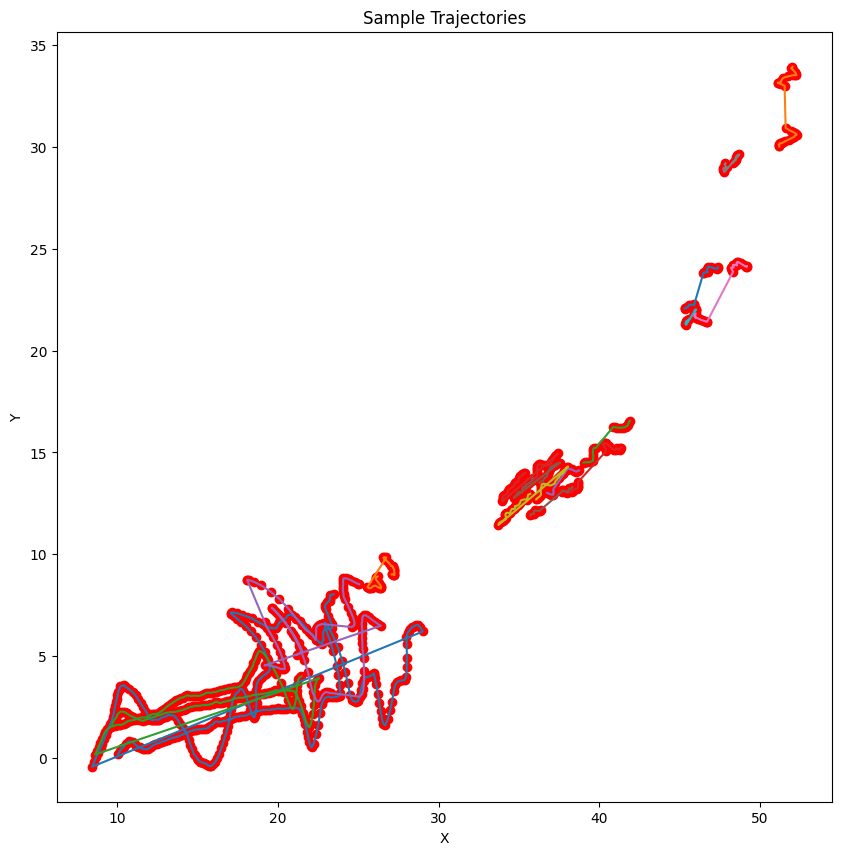

In [65]:
def plot_trajectory(trajectory, label=None):
    x, y = trajectory[:, 0], trajectory[:, 1]
    plt.plot(x, y, label=label)
    plt.scatter(x, y, c='r')  # To show individual points
    plt.xlabel('X')
    plt.ylabel('Y')

# Assuming `trajectories` is an array of shape (num_samples, sequence_length, 2)
plt.figure(figsize=(10, 10))
for i in range(len(pos_2d_orig)):  # Plot 10 sample trajectories
    plot_trajectory(pos_2d_orig[i])

plt.title('Sample Trajectories')
plt.show()


# Augmentation

In [98]:
df=track_df.reset_index(drop=True)
def random_rotate(df):
    augmented_df = pd.DataFrame(columns=['positions', 'poses'])

    for i,row in df.iterrows():
        yaw = np.random.uniform(-np.pi/4, np.pi/4)
        
        # Create rotation matrix for the yaw angle
        cos_yaw = np.cos(yaw)
        sin_yaw = np.sin(yaw)
        rot_mat = np.array([
            [cos_yaw, -sin_yaw, 0],
            [sin_yaw,  cos_yaw, 0],
            [      0,        0, 1]
        ])

        augmented_df.loc[i] = [np.dot(row['positions'], rot_mat.T), np.dot(row['poses'], rot_mat.T)]
    return augmented_df

def random_translate(df):
    augmented_df = pd.DataFrame(columns=['positions', 'poses'])

    for i,row in df.iterrows():
        translation = np.random.uniform(-1.0, 1.0, 2)
        translation = np.append(translation, [0.0])
        
        augmented_df.loc[i] = [row['positions'] + translation, row['poses']]

    return augmented_df

new_df = random_rotate(df)
new_df = random_translate(new_df)

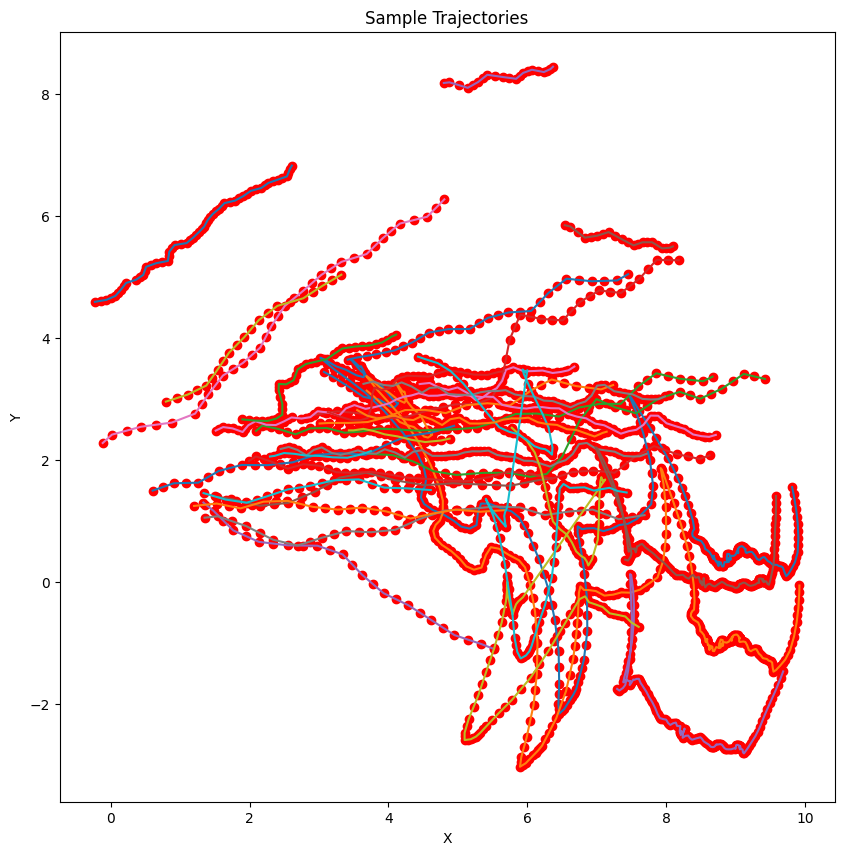

In [99]:
sequences = new_df.iloc[:]["positions"]
pos_2d = []
for s in sequences:
    pos_2d.append(s[:,:2])
def plot_trajectory(trajectory, label=None):
    x, y = trajectory[:, 0], trajectory[:, 1]
    plt.plot(x, y, label=label)
    plt.scatter(x, y, c='r')  # To show individual points
    plt.xlabel('X')
    plt.ylabel('Y')

# Assuming `trajectories` is an array of shape (num_samples, sequence_length, 2)
plt.figure(figsize=(10, 10))
for i in range(len(pos_2d_orig)):  # Plot 10 sample trajectories
    plot_trajectory(pos_2d[i])
    plot_trajectory(pos_2d_orig[i])

plt.title('Sample Trajectories')
plt.show()